In [312]:
# Libraries
import os
# os.getcwd()
from scipy.io import loadmat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from keras.models import Sequential
from keras.layers.core import Dense
import tensorflow as tf
from scipy.stats import zscore
from keras.wrappers.scikit_learn import KerasClassifier


In [287]:
# load data
path = "emails.mat"
ref = loadmat(path)
features = ref['X'].T
target = ref['Y'].T

# 1. Preprocessing

In [298]:
# convert data to DataFrame for further process

X= pd.DataFrame(features.todense())
Y = pd.DataFrame(target)

# Shape of data
X.shape, Y.shape


((10000, 57173), (10000, 1))

In [291]:
# Sparsity
#sparsity = 1 - (#nonzero/ # matrix elements)
print("sparsity =", round(1 - (np.count_nonzero(X) / X.size), 5))



sparsity = 0.99589


In [292]:
# Check for NULL values
sum(X.isna().sum()), sum(Y.isna().sum())

(0, 0)

#### Plot density and boxplot

In [293]:
# Preparing for visualizatoin
# token_length =  X.sum() # [column-wise] sum of frequency of each token per all emails 
email_length = X.sum(axis = 1) # [row-wise] sum of frequency of each token per single email

# put labels and dfx_tr (lenght of each email) in same DataFrame 
data = email_length.to_frame(name = 'length').copy()
data['target'] = Y.copy()
data.shape ,data.columns


((10000, 2), Index(['length', 'target'], dtype='object'))

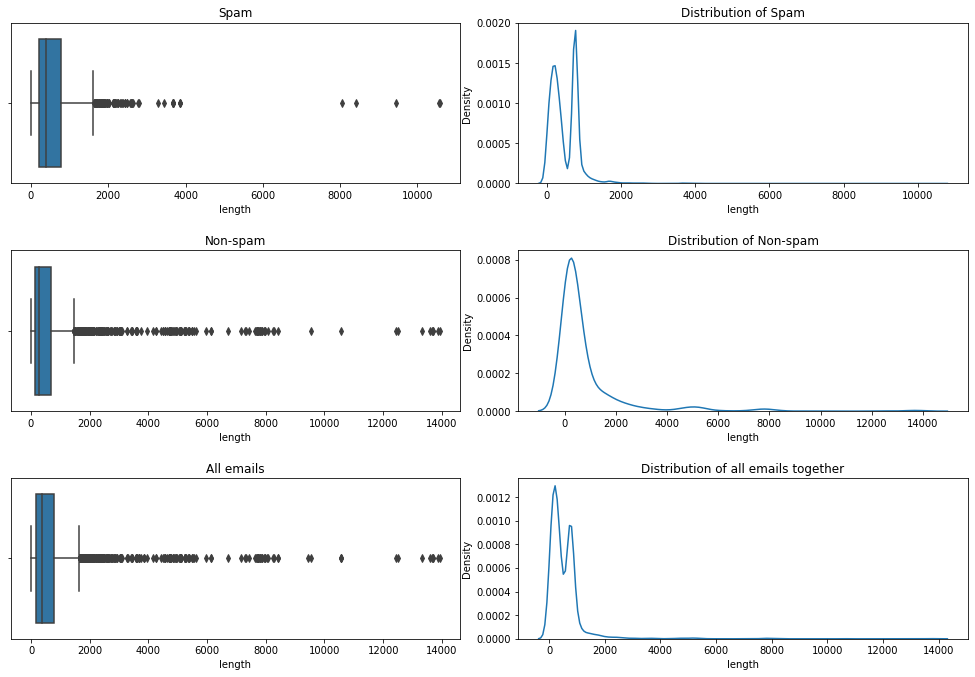

In [294]:
# density deistribution of spam and non-spam emails

plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
plt.tight_layout(pad = 5)

plt.title("Spam")
# data[data.target == 1].length.plot(kind = 'bar')
sns.boxplot(x = data[data.target == 1].length)

plt.subplot(3,2,3)
plt.title("Non-spam")
sns.boxplot(x = data[data.target == -1].length)

plt.subplot(3,2,5)
plt.title("All emails")
sns.boxplot(x = data.length)


plt.subplot(3,2,2)

plt.title("Distribution of Spam")
# data[data.target == 1].length.plot(kind = 'bar')
sns.kdeplot(data[data.target == 1].length)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) 

plt.subplot(3,2,4)
plt.title("Distribution of Non-spam")
sns.kdeplot(data[data.target == -1].length)

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) 

plt.subplot(3,2,6)
plt.title("Distribution of all emails together")
sns.kdeplot(data.length)

plt.show()


In [ ]:
# Function for explained variance by different number of component in TruncatedSVD 
def explained_variance(data,n_components):
    svd = TruncatedSVD(n_components =n_components ,n_iter=7, random_state=42)
    svd.fit(data)
    return (svd.explained_variance_ratio_).sum()



### Model fitting and hyperparameter tuning by applying nested cross-validation


In [ ]:
# load data
path = "emails.mat"
ref = loadmat(path)
X = ref['X'].T
Y = ref['Y'].T

In [299]:
# For decreasing cost and time of computation and for the sake of only showing the procedure a small slice
# of main data will be taken. Thus, performance and evaluation doesn't reflects the actual result. It is just an example.
X= X.iloc[:200, :400]
y = Y.iloc[:200].values.ravel()
# Shape of data
X.shape, y.shape


((200, 400), (200,))

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 400), (40, 400), (160,), (40,))

In [301]:
# Initializing Classifiers
# Several algorithms such as logistic regression, K-nearest neighbors, decision tree, SVC, and random forest will be tried 
clf1 = LogisticRegression(max_iter= 7000)
clf2 = KNeighborsClassifier(algorithm='ball_tree', leaf_size=50)
clf3 = DecisionTreeClassifier(random_state=1)
clf4 = SVC(random_state=1, probability=True)
clf5 = RandomForestClassifier(random_state=1)


# Building the pipelines
pipe1 = Pipeline(steps=[
                        ("svd", TruncatedSVD(n_iter=7, random_state=42)),
                        ("scaler", StandardScaler()),
                        ("clf1",clf1 )])

pipe2 = Pipeline(steps=[
                        ("svd", TruncatedSVD(n_iter=7, random_state=42)),
                        ("scaler", StandardScaler()),
                        ("clf2", clf2)])
pipe3 = Pipeline(steps=[
                        ("svd", TruncatedSVD(n_iter=7, random_state=42)),
                        ("clf3", clf3)])
pipe4 = Pipeline(steps=[
                        ("svd", TruncatedSVD(n_iter=7, random_state=42)),
                        ("scaler", StandardScaler()),
                        ("clf4", clf4)])
pipe5 = Pipeline(steps=[
                        ("svd", TruncatedSVD(n_iter=7, random_state=42)),
                        ("clf5", clf5)])



# Setting up the parameter grids
param_grid1 = [{
                'svd__n_components':[100,200,300],
                'clf1__penalty': ['l2'],
                'clf1__C':[.1, 1, 10],
                'clf1__solver':['lbfgs','saga','newton-cg']},
                {
                'svd__n_components':[100,200,300],
                'clf1__penalty': ['l1'],                
                'clf1__C':[.1, 1, 10],
                'clf1__solver':['liblinear','saga']}
                ]
param_grid2 = [{
                'svd__n_components':[100,200,300],                
                'clf2__n_neighbors': list(range(1, 10)),
                'clf2__p': [1, 2]}]

param_grid3 = {
                'svd__n_components':[100,200,300],                
                'clf3__max_depth': list(range(1, 10)) + [None],
                'clf3__criterion': ['gini', 'entropy']}

param_grid4 = [{
                'svd__n_components':[100,200,300],
                'clf4__kernel': ['rbf'],
                'clf4__C': np.power(10., np.arange(-4, 4)),
                'clf4__gamma': np.power(10., np.arange(-5, 0))},
               {
                'svd__n_components':[100,200,300],
                'clf4__kernel': ['linear'],
                'clf4__C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{
                'svd__n_components':[100,200,300],
                'clf5__n_estimators': [10, 100, 500, 1000, 10000]}]



In [302]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5),
                            (pipe1, pipe2, pipe3, pipe4, pipe5 ),
                            ('LogisticReg', 'KNN', 'DTree', 'SVM', 'RForest' )):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [303]:
# Implementing nested cross-validation
# Fitting model on inner loop and outer loop of training set
for name, gs_est in sorted(gridcvs.items()):

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    outer_scores = []
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        
        gridcvs[name].fit(X_train.iloc[train_idx,:], y_train[train_idx]) # run inner loop hyperparam tuning
        print('\n        Best ACC (avg. of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        
        # perf on test fold (valid_idx)
        outer_scores.append(gridcvs[name].best_estimator_.score(X_train.iloc[valid_idx,:], y_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % 
              (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best ACC (avg. of inner test folds) 83.59%
        Best parameters: {'clf3__criterion': 'gini', 'clf3__max_depth': 1, 'svd__n_components': 100}
        ACC (on outer test fold) 87.50%

        Best ACC (avg. of inner test folds) 82.03%
        Best parameters: {'clf3__criterion': 'gini', 'clf3__max_depth': 1, 'svd__n_components': 200}
        ACC (on outer test fold) 96.88%

        Best ACC (avg. of inner test folds) 85.94%
        Best parameters: {'clf3__criterion': 'gini', 'clf3__max_depth': 1, 'svd__n_components': 100}
        ACC (on outer test fold) 84.38%

        Best ACC (avg. of inner test folds) 84.38%
        Best parameters: {'clf3__criterion': 'gini', 'clf3__max_depth': 1, 'svd__n_components': 100}
        ACC (on outer test fold) 81.25%

        Best ACC (avg. of inner test folds) 85.94%
        Best parameters: {'clf3__criterion': 'gini', 'clf3__max_depth': 2, 'svd__n_compone

In [304]:
# Fitting best estiamtor of test set
# The best estiamtor can be defferent time to time because of randomness of K-fold.
gcv_model_select = GridSearchCV(estimator=pipe5,
                                param_grid=param_grid5,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best CV accuracy: 84.38%
Best parameters: {'clf5__n_estimators': 10, 'svd__n_components': 200}


### Model evaluation

In [308]:
# Function for visualizing performance of best estiamtor.

def model_accuracy(X_train, y_train, X_test, y_test, model):
    y_train_pred_=model.predict(X_train)
    y_test_pred_=model.predict(X_test)
    train_acc = accuracy_score(y_true=y_train, y_pred=y_train_pred_)
    test_acc = accuracy_score(y_true=y_test, y_pred=y_test_pred_)

    print('Training Accuracy: %.2f%%' % (100 * train_acc))
    print('Test Accuracy: %.2f%%' % (100 * test_acc))

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_test_pred_).ravel()
    print('legitimat_prediction_rate: %.2f%%' % ((fp + fn) /len(y_test)))
    target_names = ['Spam', 'Non-spam']
    print(classification_report(y_test, y_test_pred_, target_names=target_names, zero_division= 1))
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="auc="+str(round(auc, 3)))
    plt.title("ROC Curve")
    plt.legend(loc=4)
    
    return plt.show()


Training Accuracy: 90.62%
Test Accuracy: 77.50%
legitimat_prediction_rate: 0.23%
              precision    recall  f1-score   support

        Spam       0.50      0.22      0.31         9
    Non-spam       0.81      0.94      0.87        31

    accuracy                           0.78        40
   macro avg       0.65      0.58      0.59        40
weighted avg       0.74      0.78      0.74        40



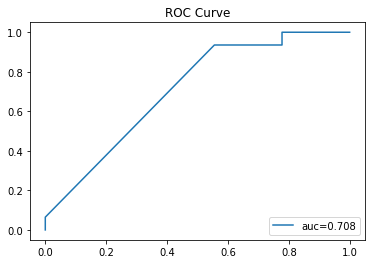

In [309]:
# Applying model_accuracy function
model_accuracy(X_train, y_train, X_test, y_test, gcv_model_select)

### Fitting Neural Network and hyperparameter tuning by applying nested cross-validation


In [257]:
# Hyperparameters such as different unites of dense layers, optimizers, batch_size and epochs will be tuned.
# Function to create model, required for KerasClassifier
def create_model(unit1, unit2, optimizer):
	# create model
	model = Sequential()
	model.add(Dense(unit1, input_shape=(X_train.shape[1],), activation='relu'))
	model.add(Dense(unit2, activation='relu'))
	model.add(Dense(20, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer =optimizer , metrics=['accuracy'], run_eagerly=True)
	return model

# create model
model = KerasClassifier(model=create_model, verbose=0)

# define the grid search parameters
unit1 = [100,80]
unit2 = [80, 60]
optimizer = ['SGD','Adam', 'Adamax'] #, 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
batch_size = [30, 60]
epochs = [20, 30]
param_grid = dict(model__unit1=unit1, model__unit2=unit2 ,model__optimizer=optimizer,batch_size=batch_size, epochs=epochs)
# param_grid = dict(model__unit1=unit1, model__unit2=unit2,model__optimizer=optimizer)


In [258]:
# Fitting models of entire traing data

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=inner_cv)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.862451 using {'batch_size': 30, 'epochs': 30, 'model__optimizer': 'Adam', 'model__unit1': 80, 'model__unit2': 80}
0.800023 (0.023258) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'SGD', 'model__unit1': 100, 'model__unit2': 80}
0.806429 (0.030732) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'SGD', 'model__unit1': 100, 'model__unit2': 60}
0.818891 (0.034707) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'SGD', 'model__unit1': 80, 'model__unit2': 80}
0.818775 (0.038616) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'SGD', 'model__unit1': 80, 'model__unit2': 60}
0.831120 (0.041210) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'Adam', 'model__unit1': 100, 'model__unit2': 80}
0.824948 (0.023857) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'Adam', 'model__unit1': 100, 'model__unit2': 60}
0.831237 (0.015477) with: {'batch_size': 30, 'epochs': 20, 'model__optimizer': 'Adam', 'model__unit1': 80, 'model__u

In [259]:
# Implementing nested cross-validation
# Fitting model on inner loop and outer loop of training set

outer_scores = []
best_params = []
best_inner_scores = []
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)


for train_idx, valid_idx in outer_cv.split(X_train, y_train):

    grid_result.fit(X_train.iloc[train_idx,:], y_train[train_idx]) # run inner loop hyperparam tuning
    best_inner_scores.append(grid_result.best_score_)   
    best_params.append(grid_result.best_params_)
    # perf on test fold (valid_idx)
    outer_scores.append(grid_result.best_estimator_.score(X_train.iloc[valid_idx,:], y_train[valid_idx]))

print('\n    Outer Loop:')
print('        ACC %.2f%% +/- %.2f' % 
            (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))
print('\n    Inner Loop:')
print('        ACC %.2f%% +/- %.2f' % 
            (np.mean(best_inner_scores) * 100, np.std(best_inner_scores) * 100))

best_params_ = pd.DataFrame(best_params)
best_params_['best_outetr_score']  = outer_scores
best_params_['best_inner_score']  = best_inner_scores
best_params_["model"] = best_params_.index
best_params_ = best_params_.set_index('model')
best_params_


    Outer Loop:
        ACC 81.88% +/- 7.76

    Inner Loop:
        ACC 84.53% +/- 1.62


,batch_size,epochs,model__optimizer,model__unit1,model__unit2,best_outetr_score,best_inner_score
model,,,,,,,
0,60,20,SGD,100,80,0.78125,0.828165
1,60,20,SGD,80,80,0.84375,0.843485
2,60,30,SGD,100,60,0.90625,0.827796
3,30,30,Adam,100,80,0.87500,0.859173
4,30,20,Adamax,100,80,0.68750,0.867848


Best model:
  model 2
Best model's parameteres:
 {'batch_size': 60, 'epochs': 30, 'model__optimizer': 'SGD', 'model__unit1': 100, 'model__unit2': 60}
Training Accuracy: 85.62%
Test Accuracy: 85.00%
legitimat_prediction_rate: 0.15%
              precision    recall  f1-score   support

        Spam       0.00      0.00      0.00         5
    Non-spam       0.87      0.97      0.92        35

    accuracy                           0.85        40
   macro avg       0.44      0.49      0.46        40
weighted avg       0.76      0.85      0.80        40



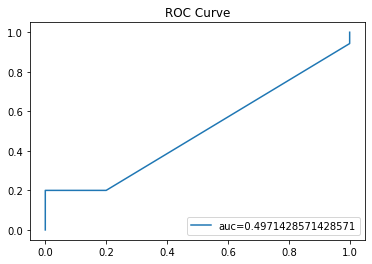

In [279]:
# Based on the above table we can decide on which model to choose. The model with
# a higher score in the outer part of training data, could be chosen for the test set.
models = best_params_.copy()

models_ = models.iloc[np.argmax(models.best_outetr_score),:5].to_dict()
grid_result.best_estimator_.set_params(**models_)

best_model = grid_result.best_estimator_.fit(X_train, y_train)
print(f"Best model:\n  model", np.argmax(models.best_outetr_score))
print(f"Best model's parameteres:\n", models_)
model_accuracy(X_train, y_train, X_test, y_test, best_model)

### Models comparison

In [261]:
# Function for plotting area under cureve (auc) of each model

def models_auc(X_train, y_train, X_test, y_test,grid_result, best_params_):
    for i in  range(best_params_.shape[0]):
    
        best_params__ = best_params_.iloc[i,:5].to_dict()
        grid_result.best_estimator_.set_params(**best_params__)
        grid_result.best_estimator_
        best_model = grid_result.best_estimator_.fit(X_train, y_train)


        y_pred_proba = best_model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="model"+str(i)+ " auc="+str(round(auc, 3)))
        plt.title("ROC Curve")
        plt.legend(loc=2)
        
    return         



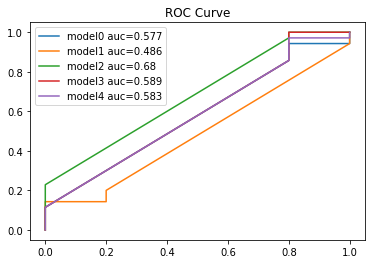

In [262]:
# Polt shows each models performance according to its auc rate. The cureve closer to top and left side of the figure has higher auc.
models = best_params_.copy()
models_auc(X_train, y_train, X_test, y_test,grid_result, models)